In [1]:
import sys
sys.path.append("/hpc/home/ps325/projects/velorama/velorama")

import gaston_dynamics as gd
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch
import sys
from importlib import reload


sys.path.append("/hpc/home/ps325/projects/gaston-velorama/src/gaston-base")

import gaston


import seaborn as sns
import math

In [3]:
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, restrict_spots, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

In [4]:
CDATADIR = "gaston-base/gaston/docs/notebooks/tutorials/"

In [5]:
data_folder= CDATADIR + 'colorectal_tumor_data'
use_RGB=True # set to False if you do not want to use RGB as features

counts_mat, coords_mat, gene_labels, rgb_mean=parse_adata.get_gaston_input_adata(data_folder, get_rgb=use_RGB, spot_umi_threshold=50)

# save matrices
np.save(CDATADIR + 'colorectal_tumor_data/counts_mat.npy', counts_mat)
np.save(CDATADIR + 'colorectal_tumor_data/coords_mat.npy', coords_mat)
np.save(CDATADIR + 'colorectal_tumor_data/gene_labels.npy', gene_labels)


/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


removing spots with UMI count < 50


/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


calculating RGB


  0%|          | 0/3902 [00:00<?, ?/s]

Traceback (most recent call last):
  File "/hpc/group/singhlab/tools/conda/miniconda3/envs/py39cuda115_ps325/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/hpc/group/singhlab/tools/conda/miniconda3/envs/py39cuda115_ps325/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/hpc/group/singhlab/tools/conda/miniconda3/envs/py39cuda115_ps325/lib/python3.9/multiprocessing/managers.py", line 591, in _run_server
    server.serve_forever()
  File "/hpc/group/singhlab/tools/conda/miniconda3/envs/py39cuda115_ps325/lib/python3.9/multiprocessing/managers.py", line 184, in serve_forever
    sys.exit(0)
SystemExit: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/hpc/group/singhlab/tools/conda/miniconda3/envs/py39cuda115_ps325/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/hpc/group/s

In [6]:
# # GLM-PCA parameters
# num_dims=5
# penalty=20 # may need to increase if this is too small

# # CHANGE THESE PARAMETERS TO REDUCE RUNTIME
# num_iters=30
# eps=1e-4
# num_genes=10000

# counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
# glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
#                         ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
# A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

# if use_RGB:
#     A=np.hstack((A,rgb_mean)) # attach to RGB mean
# np.save(CDATADIR + 'colorectal_tumor_data/glmpca.npy', A)

In [7]:
A=np.load(CDATADIR + 'colorectal_tumor_data/glmpca.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [8]:
# gaston_model, A, S = gd.gaston_model('tutorial_outputs', S_torch, A_torch)
gaston_model, A, S= process_NN_output.process_files(CDATADIR + 'colorectal_tumor_data/reproduce_tumor')


best model: gaston-base/gaston/docs/notebooks/tutorials/colorectal_tumor_data/reproduce_tumor/seed23


In [9]:
import importlib
importlib.reload(gd)

df = pd.DataFrame(counts_mat, columns=gene_labels)
adata=sc.AnnData(df)
adata.obsm["coords"] = coords_mat

gaston_isodepth, gaston_labels = gd.calculate_isodepth(gaston_model, A, S, num_layers = 5, flip = True, adjust = False)
dag_adjacency_matrix = gd.construct_dag(adata,gaston_isodepth, coords_mat, n_neighbors = 6, plot = False)

/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Graph construction completed in 0.0126 seconds


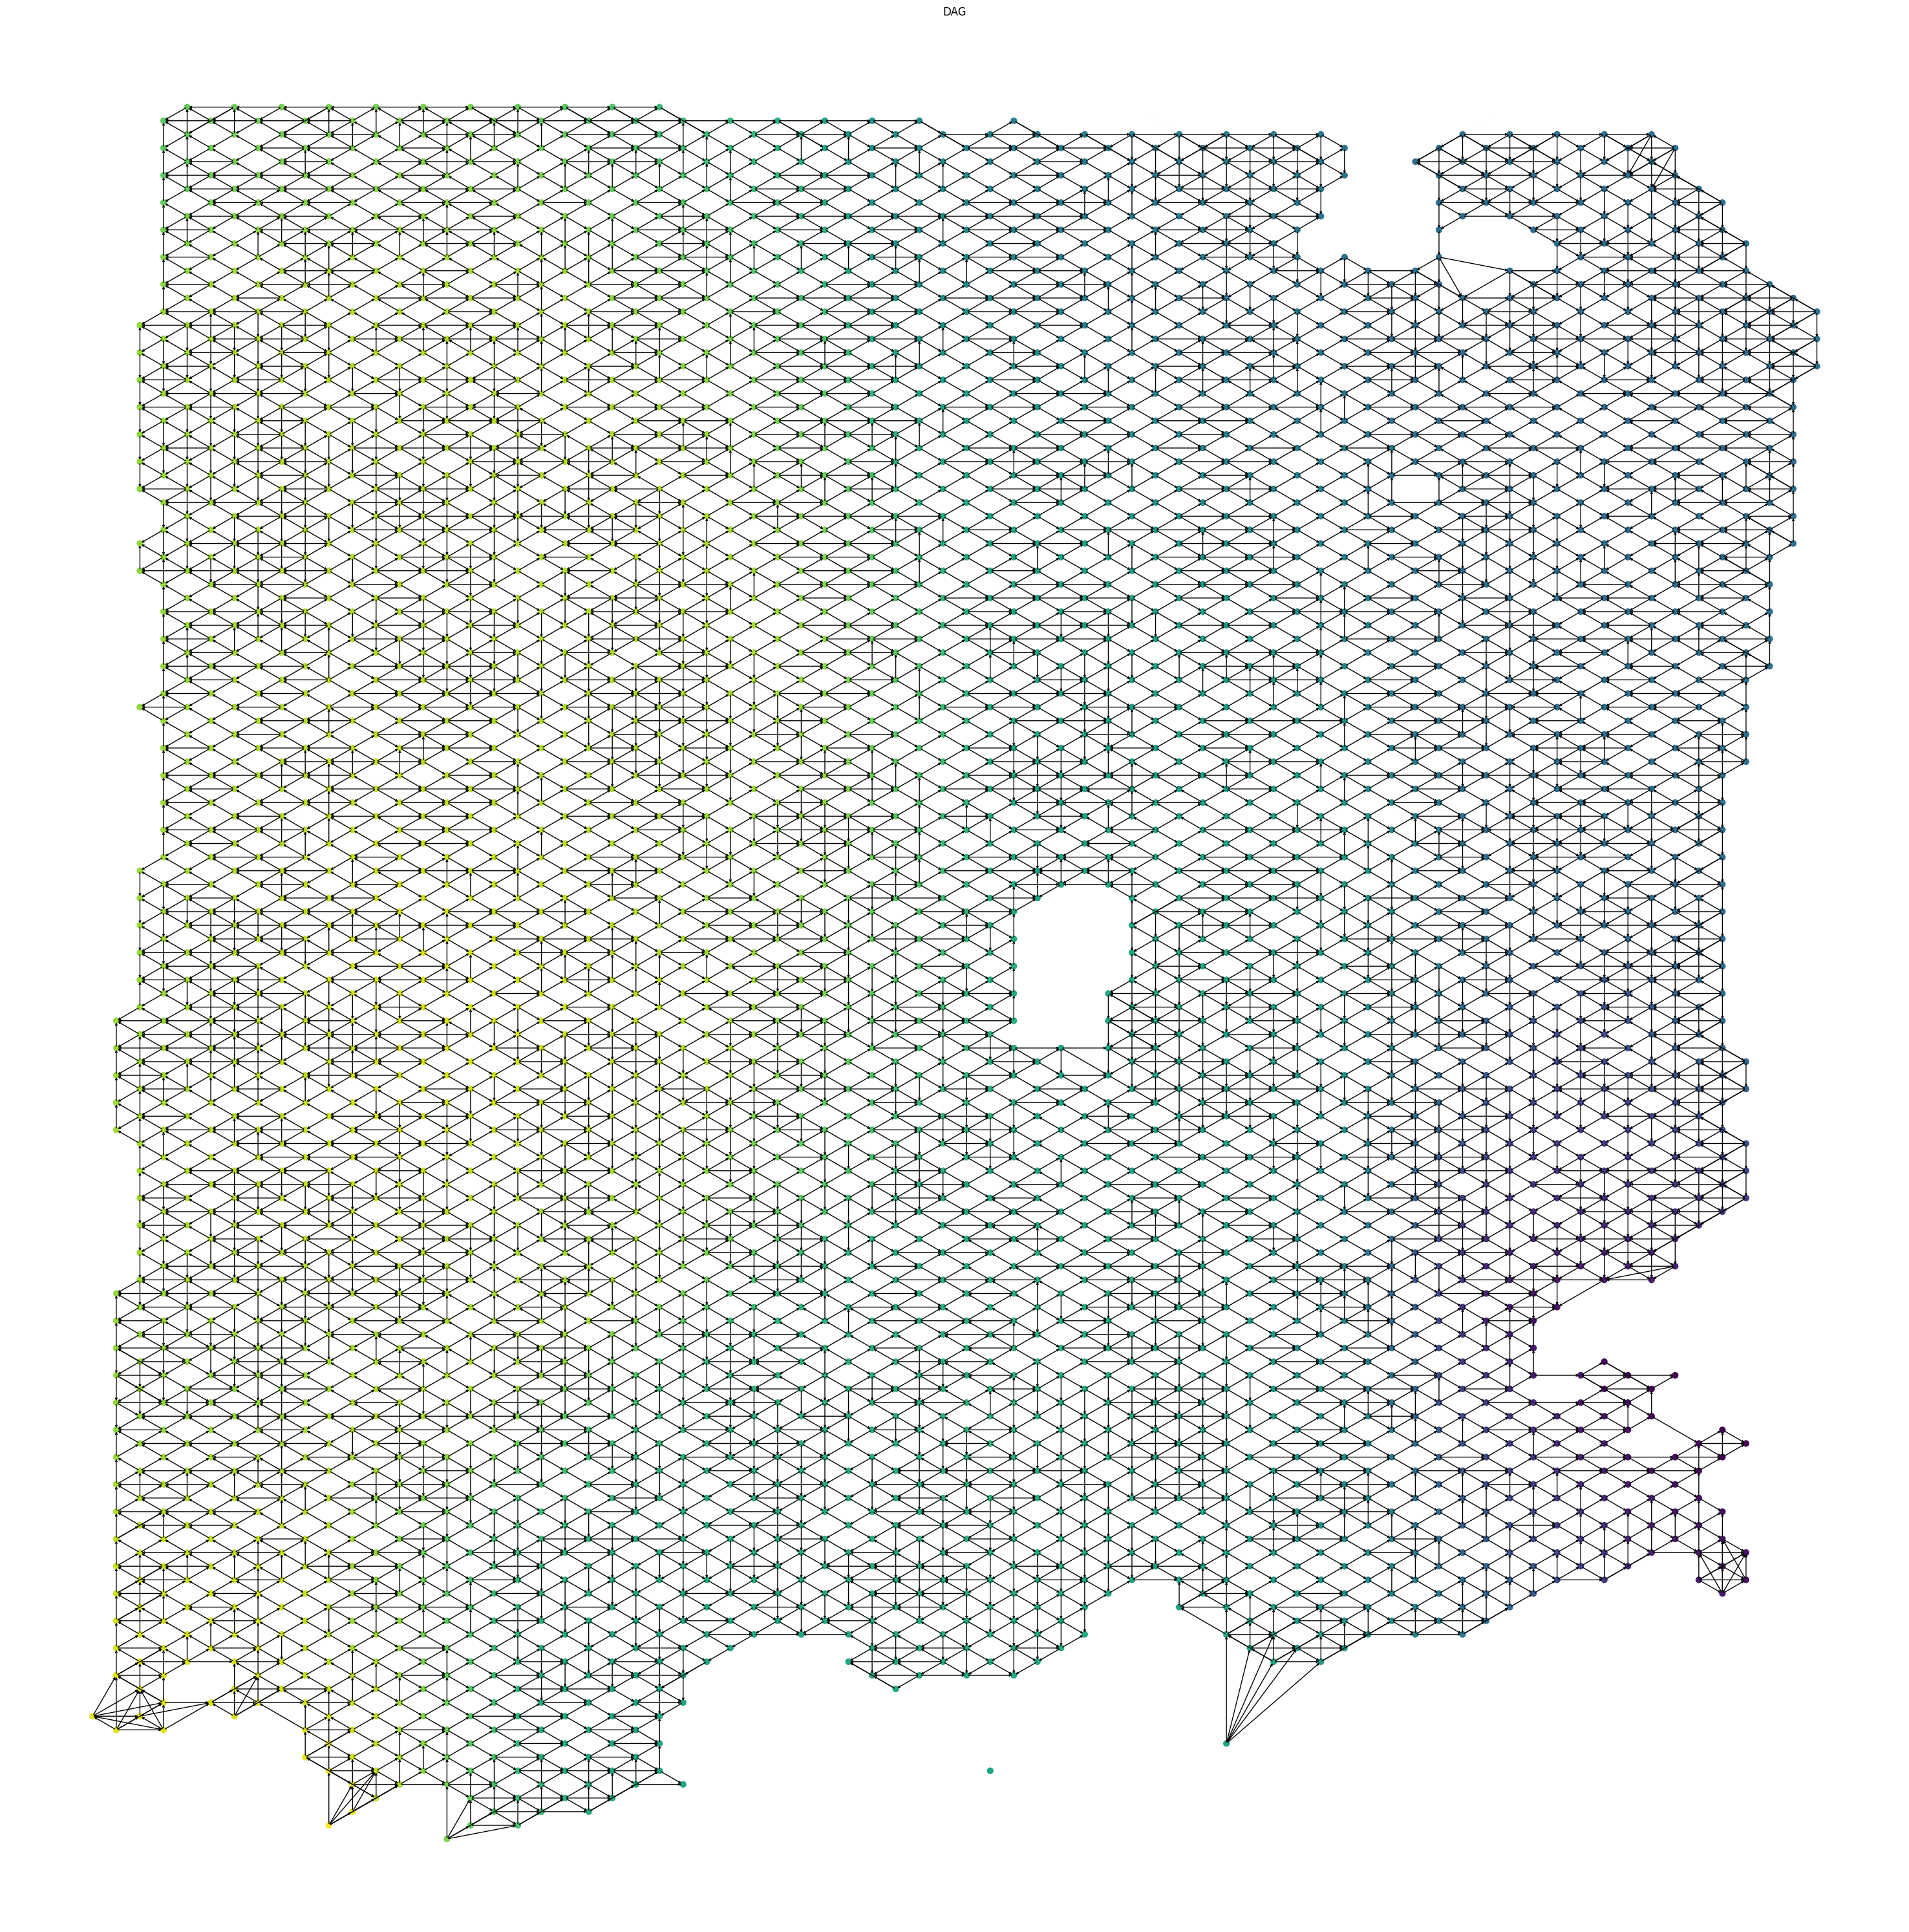

In [10]:
importlib.reload(gd)

gd.plot_spatial_dag(dag_adjacency_matrix, coords_mat, gaston_isodepth, size=40)

In [11]:
umi_thresh = 1000
idx_kept, gene_labels_idx=filter_genes.filter_genes(counts_mat, gene_labels, 
                                       umi_threshold=umi_thresh, 
                                       exclude_prefix=['MT-', 'RPL', 'RPS'])

In [12]:
# compute piecewise linear fit for restricted spots
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth,
                                        None, [],  idx_kept=idx_kept, umi_threshold=umi_thresh, isodepth_mult_factor=0.01,)
# for plotting
binning_output=binning_and_plotting.bin_data(counts_mat.T, gaston_labels, gaston_isodepth, 
                         None, gene_labels, idx_kept=idx_kept, num_bins=15, umi_threshold=umi_thresh)

Poisson regression for ALL cell types


100%|██████████| 5306/5306 [00:57<00:00, 91.65it/s]


In [13]:
q=0.9 
file = 'allTFs_hg38.txt'

targets = gd.target_list(pw_fit_dict, binning_output)
reg_set = gd.reg_list(file, pw_fit_dict, binning_output, q)

In [14]:
gd.is_target(adata, targets)
gd.is_reg(adata, reg_set)

print(adata.var)

             is_target  is_reg
MIR1302-2HG      False   False
FAM138A          False   False
OR4F5            False   False
AL627309.1       False   False
AL627309.3       False   False
...                ...     ...
AC141272.1       False   False
AC023491.2       False   False
AC007325.1       False   False
AC007325.4       False   False
AC007325.2       False   False

[36601 rows x 2 columns]


In [15]:
adata.write('/hpc/home/ps325/projects/velorama/datasets/gd_dense_full_flip.h5ad')

In [16]:
num_layers=5 # CHANGE FOR YOUR APPLICATION: use number of layers from above!
# gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# # DATASET-SPECIFIC: so domains are ordered with tumor being last
# gaston_isodepth= np.max(gaston_isodepth) -1 * gaston_isodepth
# gaston_labels=(num_layers-1)-gaston_labels

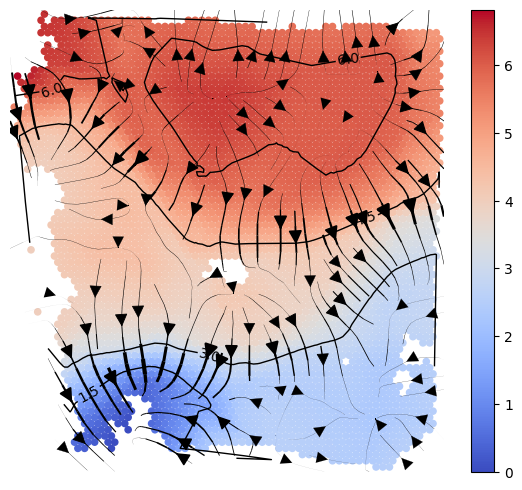

In [17]:
show_streamlines=True
rotate = np.radians(-90) # rotate coordinates by -90
arrowsize=2

cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, 
                               rotate=rotate,arrowsize=arrowsize, neg_gradient=False)

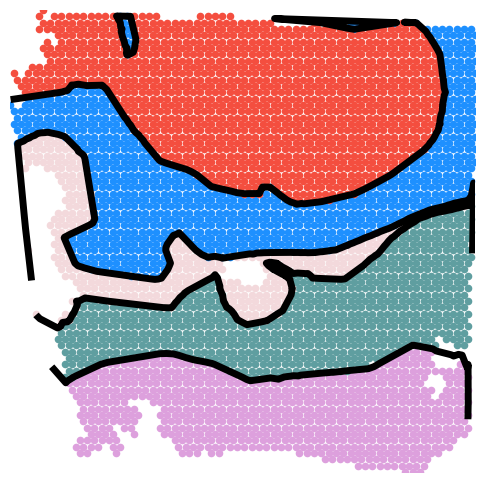

In [18]:
domain_colors=colors=['plum', 'cadetblue', '#F3D9DC','dodgerblue', '#F44E3F']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
                               colors=domain_colors, s=20, lgd=False, 
                               show_boundary=True, gaston_isodepth=gaston_isodepth, boundary_lw=5, rotate=rotate)

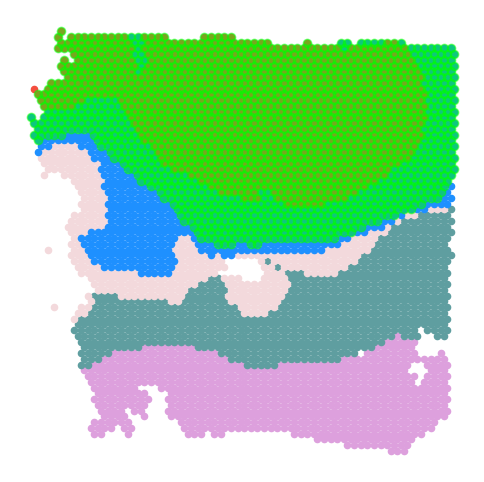

In [19]:
# This is the range we used for reproducing figure papers.
isodepth_min=4.5
isodepth_max=6.8


cluster_plotting.plot_clusters_restrict(gaston_labels, S, gaston_isodepth, 
                                        isodepth_min=isodepth_min, isodepth_max=isodepth_max, figsize=(6,6), 
                                        colors=domain_colors, s=20, lgd=False, rotate=rotate)

restricting to 1792 spots


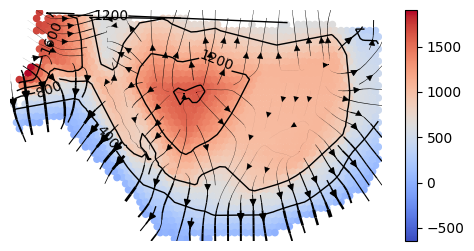

In [20]:
# Optional: adjust isodepth for physical distance
adjust_physical=True
scale_factor=100 # since distance of 1 = 100 microns for 10x Visium

# Optional: plot isodepth for green spots
plot_isodepth=True

# plotting parameters
show_streamlines=True
rotate=np.radians(-90)
arrowsize=1


counts_mat_restrict, coords_mat_restrict, gaston_isodepth_restrict, gaston_labels_restrict, S_restrict=restrict_spots.restrict_spots(
                                                             counts_mat, coords_mat, S, gaston_isodepth, gaston_labels, 
                                                             isodepth_min=isodepth_min, isodepth_max=isodepth_max, 
                                                             adjust_physical=adjust_physical, scale_factor=scale_factor,
                                                             plot_isodepth=plot_isodepth, show_streamlines=show_streamlines, 
                                                             gaston_model=gaston_model, rotate=rotate, figsize=(6,3), 
                                                             arrowsize=arrowsize, 
                                                             neg_gradient=False) # since we reversed gradient direction earlier

In [21]:
importlib.reload(gd)
gaston_isodepth_restrict=np.max(gaston_isodepth_restrict)-gaston_isodepth_restrict
df_restrict = pd.DataFrame(counts_mat_restrict, columns=gene_labels)
adata_restrict=sc.AnnData(df_restrict)
adata_restrict.obsm["coords"] = coords_mat_restrict

/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/home/ps325/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Graph construction completed in 3.3255 seconds


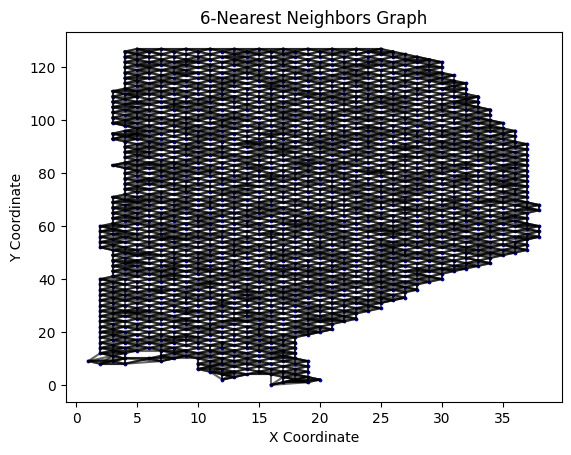

In [22]:
dag_adjacency_matrix_restrict= gd.construct_dag(adata_restrict,gaston_isodepth_restrict, coords_mat_restrict, n_neighbors = 6, plot = True)

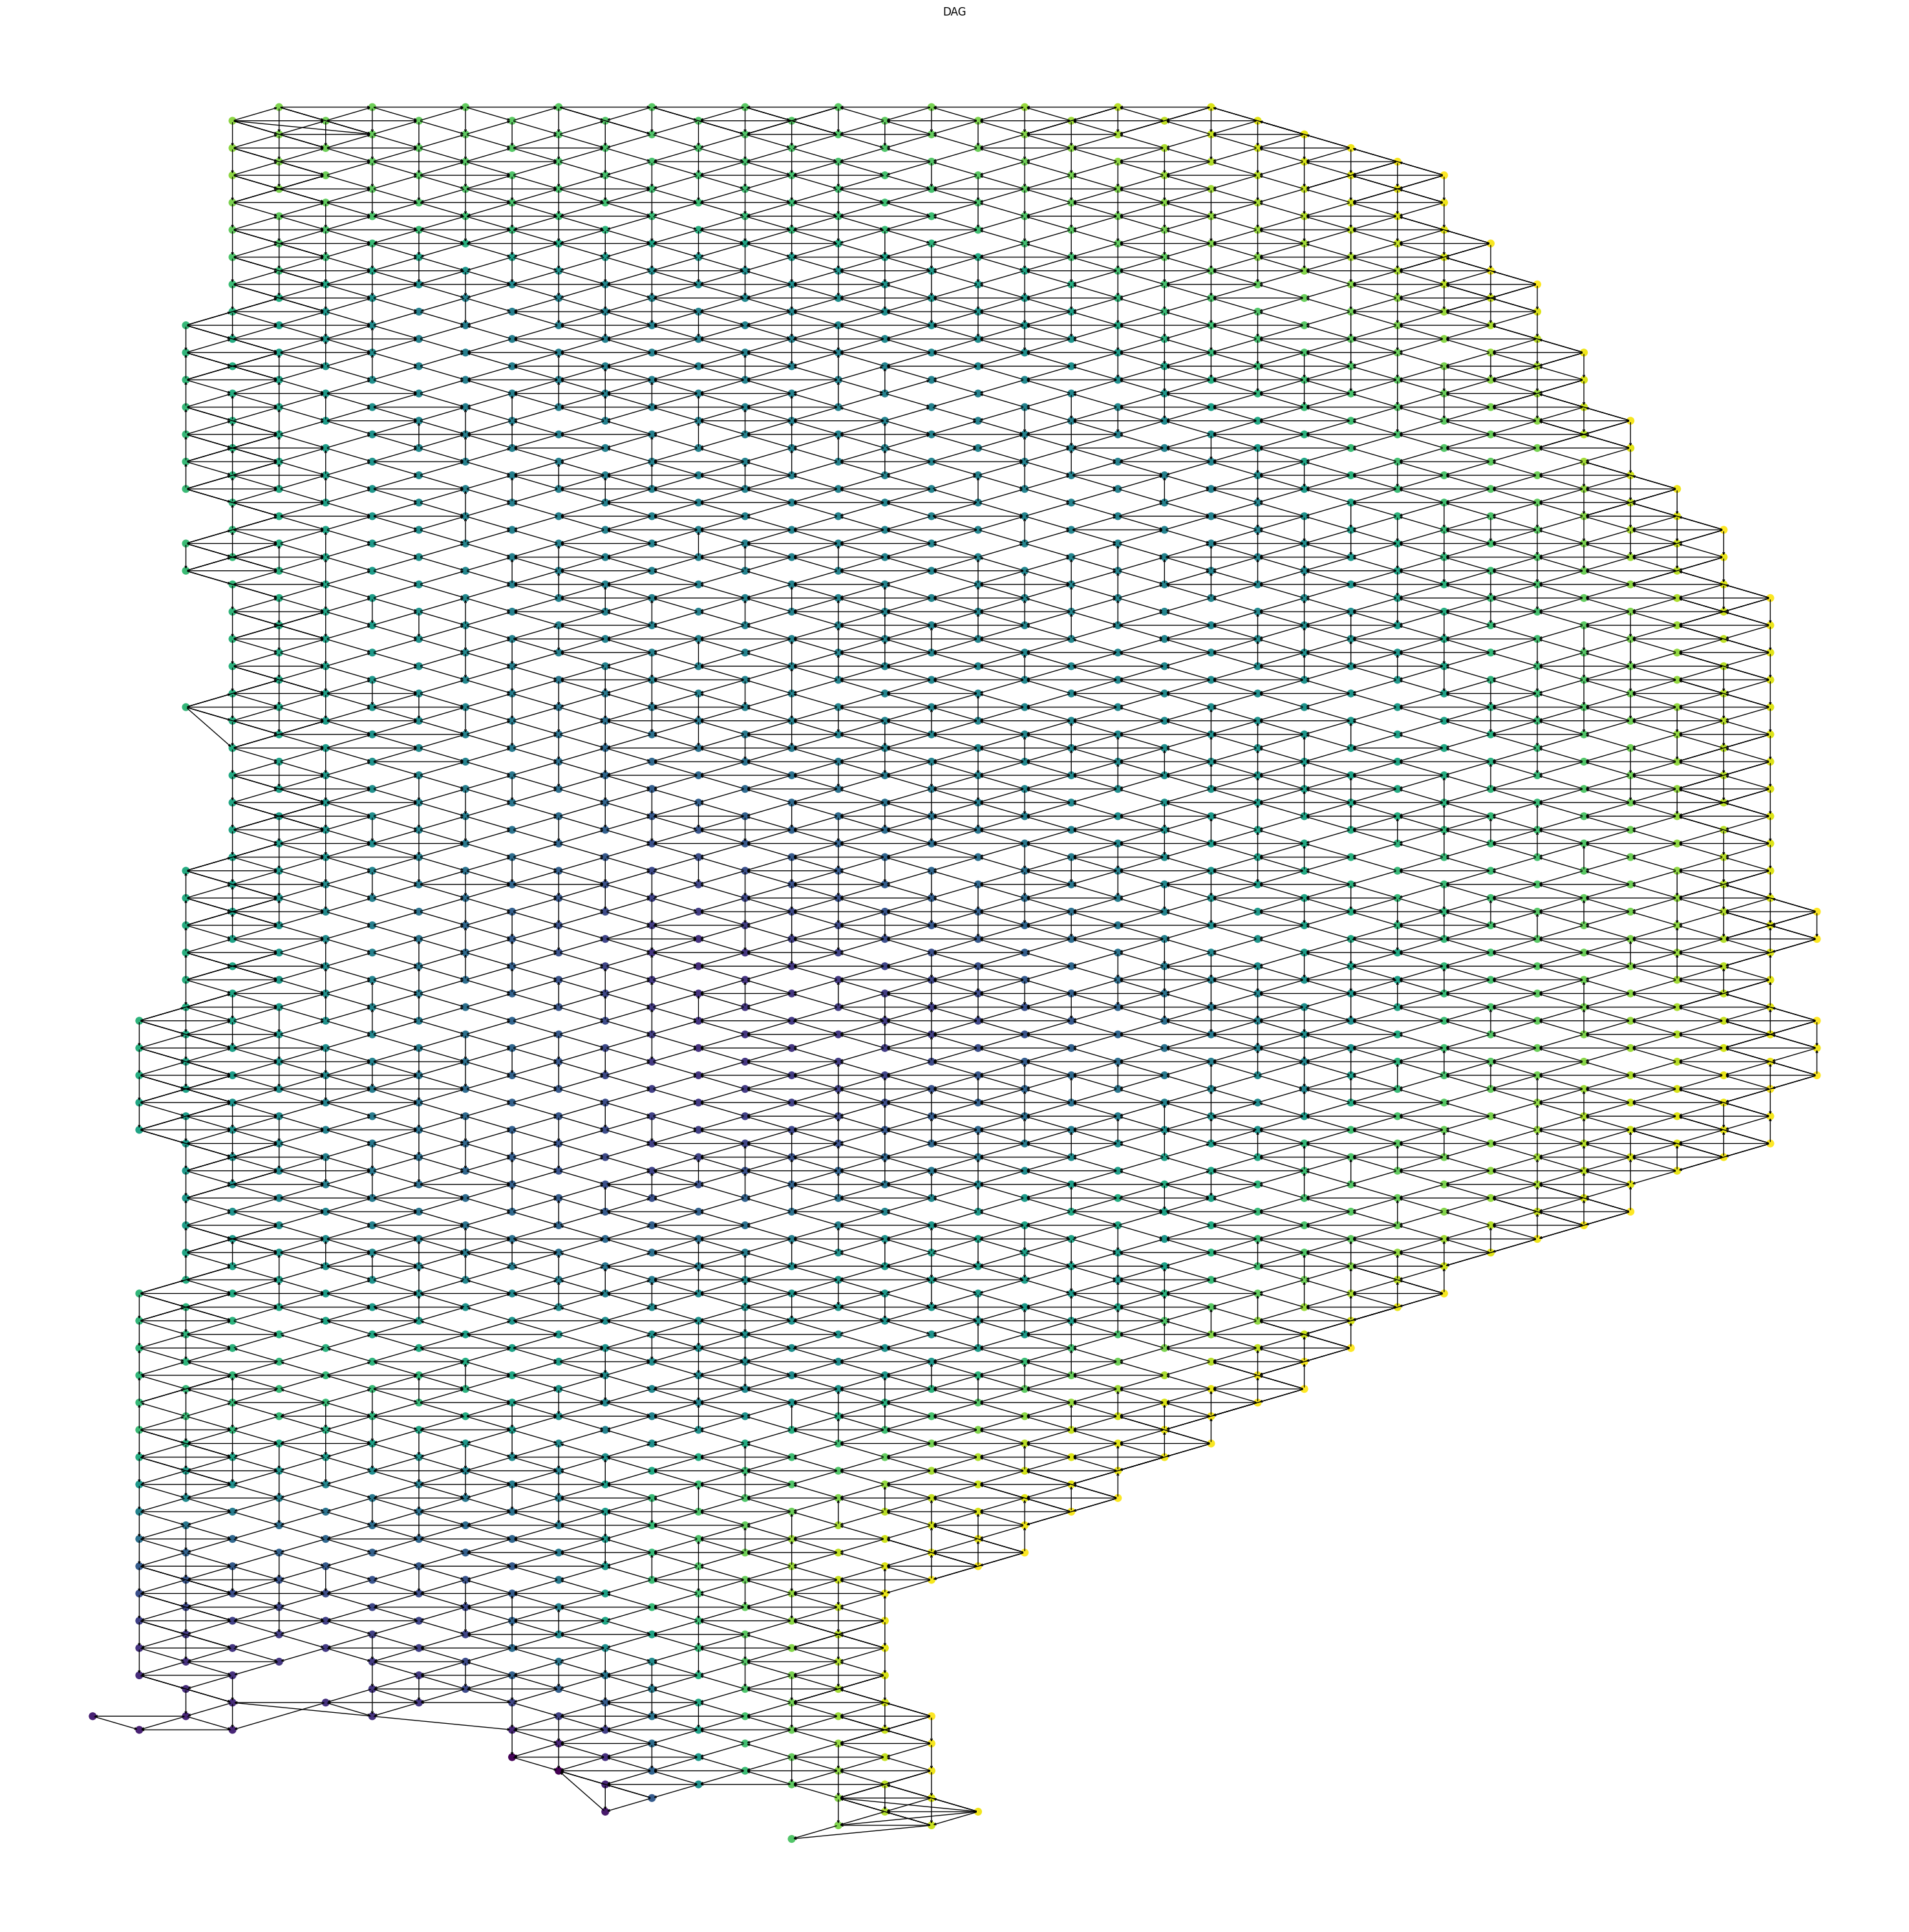

In [23]:
gd.plot_spatial_dag(dag_adjacency_matrix_restrict, coords_mat_restrict, gaston_isodepth_restrict, size = 60)

In [24]:
umi_thresh = 1000
idx_kept, gene_labels_idx=filter_genes.filter_genes(counts_mat, gene_labels, 
                                       umi_threshold=umi_thresh, 
                                       exclude_prefix=['MT-', 'RPL', 'RPS'])

In [25]:
# compute piecewise linear fit for restricted spots
pw_fit_dict_restricts=segmented_fit.pw_linear_fit(counts_mat_restrict, gaston_labels_restrict, gaston_isodepth_restrict,
                                        None, [],  idx_kept=idx_kept, umi_threshold=umi_thresh, isodepth_mult_factor=0.01,)
# for plotting
binning_output_restricts=binning_and_plotting.bin_data(counts_mat_restrict.T, gaston_labels_restrict, gaston_isodepth_restrict, 
                         None, gene_labels, idx_kept=idx_kept, num_bins=15, umi_threshold=umi_thresh)

Poisson regression for ALL cell types


100%|██████████| 5306/5306 [00:30<00:00, 171.72it/s]


In [26]:
q=0.9 
file = 'allTFs_hg38.txt'

targets_restricts = gd.target_list(pw_fit_dict_restricts, binning_output_restricts)
reg_set_restricts = gd.reg_list(file, pw_fit_dict_restricts, binning_output_restricts, q)

In [27]:
gd.is_target(adata_restrict, targets_restricts)
gd.is_reg(adata_restrict, reg_set_restricts)

print(adata_restrict.var)

             is_target  is_reg
MIR1302-2HG      False   False
FAM138A          False   False
OR4F5            False   False
AL627309.1       False   False
AL627309.3       False   False
...                ...     ...
AC141272.1       False   False
AC023491.2       False   False
AC007325.1       False   False
AC007325.4       False   False
AC007325.2       False   False

[36601 rows x 2 columns]


In [28]:
l = np.array(adata_restrict.var.index.tolist())
l[adata_restrict.var.is_target]

array(['PADI2', 'RNF186', 'TTC39A', 'CLCA1', 'HMGCS2', 'REG4',
       'LINC01133', 'ITLN1', 'MFSD4A', 'LINC01819', 'SLC9A2', 'DES',
       'C2orf72', 'B3GNT7', 'NEU4', 'HHLA2', 'SI', 'MUC4', 'SULT1B1',
       'JCHAIN', 'SLC4A4', 'CDS1', 'ATOH1', 'ADH1C', 'TGFBI', 'MZB1',
       'SPINK5', 'SLC26A2', 'BTNL8', 'ADTRP', 'HLA-G', 'SPDEF', 'NHSL1',
       'SMOC2', 'FSCN1', 'IGFBP3', 'HEPACAM2', 'ADAMDEC1', 'CA2',
       'LRRC19', 'SPINK4', 'TPM2', 'TRPM6', 'ST6GALNAC6', 'LRRC26',
       'ENTPD8', 'PBLD', 'FFAR4', 'PLCE1', 'IFITM1', 'MUC2', 'ASCL2',
       'NXPE1', 'NXPE4', 'TAGLN', 'THY1', 'SIAE', 'VSIG2', 'ST3GAL4',
       'CPM', 'RFLNA', 'ATP11A', 'ENTPD5', 'TC2N', 'AMN', 'ASPG', 'IGHA2',
       'IGHA1', 'PLA2G10', 'SCNN1B', 'CHP2', 'NUPR1', 'ZG16', 'MT1E',
       'MT1M', 'MT1F', 'MT1G', 'MT1X', 'CHST5', 'HSD17B2', 'DPEP1',
       'GGT6', 'RASD1', 'MMP28', 'ETV4', 'PRAC1', 'HOXB13', 'C3', 'FCGBP',
       'KLK1', 'TRIB3', 'TGM2', 'PCK1', 'CLDN8', 'B3GALT5', 'B3GALT5-AS1',
       'TRPM2', 'M

In [29]:
adata_restrict.write('/hpc/home/ps325/projects/velorama/datasets/gd_test_dense_res.h5ad')